<a href="https://colab.research.google.com/github/ahaffne2/64061_ahaffne2/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Copying images to training, validation, and test directories**

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/drive/MyDrive/train")
new_base_dir = pathlib.Path("cats_vs_dogs_small4000")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=4000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 128)      0         
 2D)                                                         

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

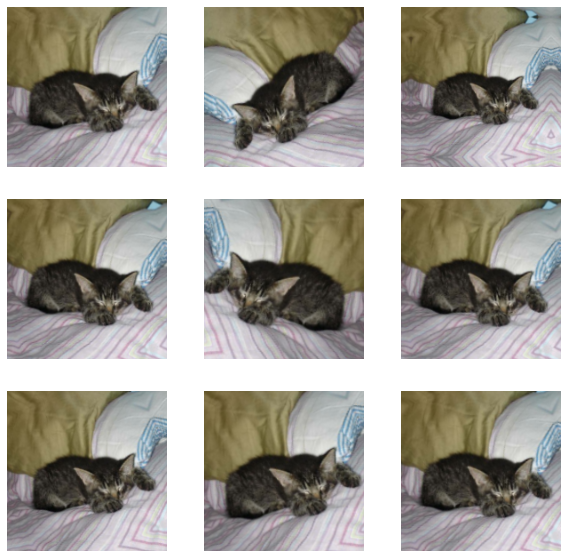

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 31s 82ms/step - loss: 0.6964 - accuracy: 0.5320 - val_loss: 0.6618 - val_accuracy: 0.6310
Epoch 2/100
250/250 [==============================] - 20s 79ms/step - loss: 0.6759 - accuracy: 0.6134 - val_loss: 0.6078 - val_accuracy: 0.6590
Epoch 3/100
250/250 [==============================] - 21s 82ms/step - loss: 0.6299 - accuracy: 0.6629 - val_loss: 0.6811 - val_accuracy: 0.6470
Epoch 4/100
250/250 [==============================] - 20s 80ms/step - loss: 0.5748 - accuracy: 0.7038 - val_loss: 0.4842 - val_accuracy: 0.7690
Epoch 5/100
250/250 [==============================] - 20s 79ms/step - loss: 0.5416 - accuracy: 0.7247 - val_loss: 0.4242 - val_accuracy: 0.8100
Epoch 6/100
250/250 [==============================] - 20s 80ms/step - loss: 0.5162 - accuracy: 0.7466 - val_loss: 0.4140 - val_accuracy: 0.8190
Epoch 7/100
250/250 [==============================] - 20s 80ms/step - loss: 0.4999 - accuracy: 0.7616 - val_loss: 0.4011 - val_ac

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 39ms/step - loss: 0.1784 - accuracy: 0.9280
Test accuracy: 0.928


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 1s/step


In [ ]:
train_features.shape

(8000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
250/250 [==============================] - 2s 5ms/step - loss: 8.9644 - accuracy: 0.9504 - val_loss: 2.2818 - val_accuracy: 0.9840
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 3.3160 - accuracy: 0.9784 - val_loss: 0.7757 - val_accuracy: 0.9940
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 1.8067 - accuracy: 0.9869 - val_loss: 1.0935 - val_accuracy: 0.9920
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 1.3377 - accuracy: 0.9900 - val_loss: 0.0897 - val_accuracy: 0.9970
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 0.8081 - accuracy: 0.9926 - val_loss: 0.5563 - val_accuracy: 0.9960
Epoch 6/20
250/250 [==============================] - 1s 4ms/step - loss: 0.6144 - accuracy: 0.9945 - val_loss: 0.1098 - val_accuracy: 0.9980
Epoch 7/20
250/250 [==============================] - 1s 4ms/step - loss: 0.5013 - accuracy: 0.9951 - val_loss: 0.0150 - val_accuracy: 0.9980
Epoch 

**Plotting the results**

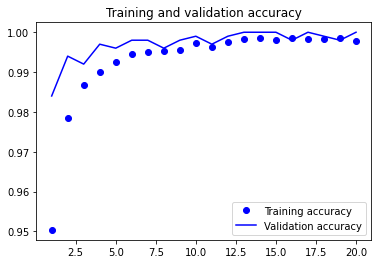

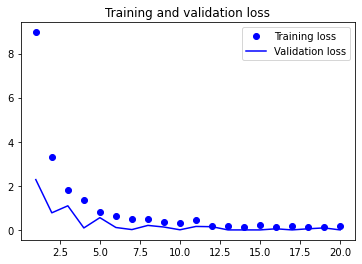

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
250/250 [==============================] - 42s 162ms/step - loss: 10.8832 - accuracy: 0.9299 - val_loss: 5.8996 - val_accuracy: 0.9660
Epoch 2/50
250/250 [==============================] - 40s 160ms/step - loss: 5.5618 - accuracy: 0.9517 - val_loss: 2.0152 - val_accuracy: 0.9820
Epoch 3/50
250/250 [==============================] - 40s 161ms/step - loss: 3.2389 - accuracy: 0.9567 - val_loss: 1.2746 - val_accuracy: 0.9790
Epoch 4/50
250/250 [==============================] - 42s 165ms/step - loss: 1.8977 - accuracy: 0.9620 - val_loss: 0.9862 - val_accuracy: 0.9800
Epoch 5/50
250/250 [==============================] - 40s 160ms/step - loss: 1.3863 - accuracy: 0.9603 - val_loss: 0.3089 - val_accuracy: 0.9850
Epoch 6/50
250/250 [==============================] - 40s 158ms/step - loss: 0.8065 - accuracy: 0.9604 - val_loss: 0.3403 - val_accuracy: 0.9830
Epoch 7/50
250/250 [==============================] - 40s 159ms/step - loss: 0.6943 - accuracy: 0.9638 - val_loss: 0.3374 - val_a

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 115ms/step - loss: 0.1905 - accuracy: 0.9950
Test accuracy: 0.995


### Fine-tuning a pretrained model

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
250/250 [==============================] - 48s 184ms/step - loss: 0.6902 - accuracy: 0.9799 - val_loss: 0.3994 - val_accuracy: 0.9890
Epoch 2/30
250/250 [==============================] - 46s 182ms/step - loss: 0.5365 - accuracy: 0.9781 - val_loss: 0.4969 - val_accuracy: 0.9900
Epoch 3/30
250/250 [==============================] - 46s 182ms/step - loss: 0.3746 - accuracy: 0.9811 - val_loss: 0.2082 - val_accuracy: 0.9970
Epoch 4/30
250/250 [==============================] - 46s 182ms/step - loss: 0.3833 - accuracy: 0.9818 - val_loss: 0.2367 - val_accuracy: 0.9920
Epoch 5/30
250/250 [==============================] - 46s 183ms/step - loss: 0.2929 - accuracy: 0.9819 - val_loss: 0.1674 - val_accuracy: 0.9960
Epoch 6/30
250/250 [==============================] - 46s 182ms/step - loss: 0.2765 - accuracy: 0.9866 - val_loss: 0.1251 - val_accuracy: 0.9960
Epoch 7/30
250/250 [==============================] - 47s 188ms/step - loss: 0.1873 - accuracy: 0.9884 - val_loss: 0.1956 - val_ac

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 114ms/step - loss: 0.0073 - accuracy: 0.9990
Test accuracy: 0.999


## Summary